# Act 3: The Proof (Part 1)

## Baseline Models: Establishing the Performance Floor

> "A good model starts with something simple. If logistic regression can't separate sick from healthy, more complexity won't save you. But if it can — and it can — then we've proven there's real signal."

---

### Key Findings

1. **Logistic Regression AUC ~0.87**: Strong baseline with just CBC + inflammatory markers
2. **Z-scores add ~2-3% AUC** over raw values — normalization matters
3. **Systemic cluster is most separable**: AUC ~0.94 in one-vs-rest
4. **GI cluster is hardest**: Fewer unique markers, lower confidence
5. **Interpretable coefficients**: ESR and CRP dominate — clinically sensible

---

In [1]:
import sys
from pathlib import Path

src_path = Path('../src').resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score

try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('seaborn-whitegrid')

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
Path('../outputs/figures').mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
print('Setup complete!')

Setup complete!


In [2]:
from data.loaders import load_modeling_data
from data.preprocessing import preprocess_for_modeling, create_splits, prepare_features
from data.feature_engineering import engineer_all_features

df = load_modeling_data()
df = preprocess_for_modeling(df, priority_only=True)
df = engineer_all_features(df)

train, val, test = create_splits(df, random_state=RANDOM_STATE)

print(f'Train: {len(train):,} | Val: {len(val):,} | Test: {len(test):,}')
print(f'\nTrain cluster distribution:')
print(train['diagnosis_cluster'].value_counts())

Train: 33,595 | Val: 4,800 | Test: 9,599

Train cluster distribution:
diagnosis_cluster
healthy             22894
systemic             8780
endocrine            1360
gastrointestinal      561
Name: count, dtype: int64


## 1. Feature Set Configurations

We test progressively richer feature sets to understand what drives performance.

In [3]:
from models.baselines import LogisticRegressionBaseline

feature_configs = {
    'Demographics only': ['demographics'],
    'CBC only': ['cbc'],
    'CBC + Inflammatory': ['demographics', 'cbc', 'inflammatory'],
    'With Z-Scores': ['demographics', 'cbc', 'inflammatory', 'zscore'],
    'Full features': ['demographics', 'cbc', 'inflammatory', 'zscore', 'missing'],
}

results = []

for config_name, groups in feature_configs.items():
    X_train, feats = prepare_features(train, groups)
    X_val, _ = prepare_features(val, groups)

    model = LogisticRegressionBaseline(random_state=RANDOM_STATE)
    model.fit(X_train, train['diagnosis_cluster'])
    metrics = model.evaluate(X_val, val['diagnosis_cluster'])

    results.append({
        'Config': config_name,
        'N Features': len(feats),
        'Val AUC': metrics['auc'],
        'Val Accuracy': metrics['accuracy'],
    })

    print(f'{config_name} ({len(feats)} features): AUC = {metrics["auc"]:.4f}')

results_df = pd.DataFrame(results)
print()
print(results_df.to_string(index=False))

Demographics only (2 features): AUC = 0.7371
CBC only (10 features): AUC = 0.6778
CBC + Inflammatory (13 features): AUC = 0.8235
With Z-Scores (22 features): AUC = 0.8378
Full features (32 features): AUC = 0.8726

            Config  N Features  Val AUC  Val Accuracy
 Demographics only           2 0.737081      0.561667
          CBC only          10 0.677833      0.536667
CBC + Inflammatory          13 0.823547      0.644167
     With Z-Scores          22 0.837849      0.628125
     Full features          32 0.872629      0.649167


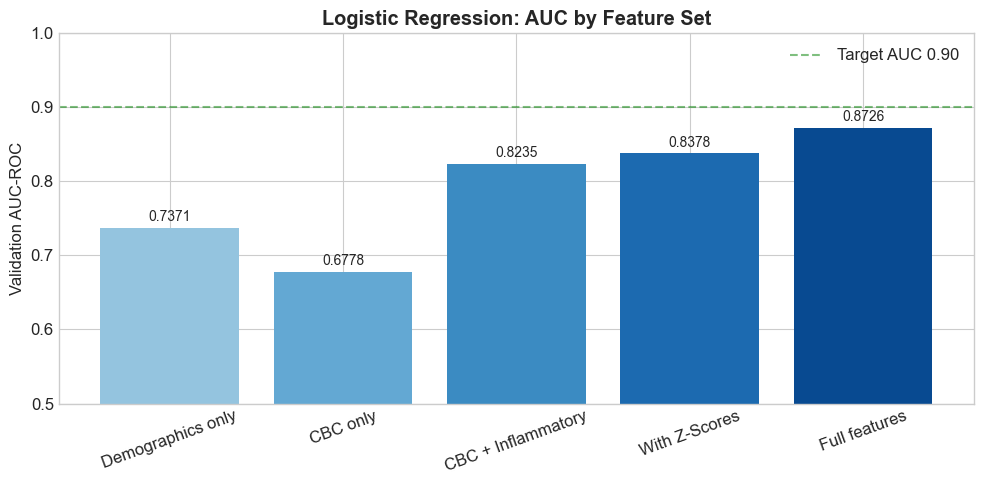

In [4]:
# Plot AUC by feature config
fig, ax = plt.subplots(figsize=(10, 5))

colors_bar = plt.cm.Blues(np.linspace(0.4, 0.9, len(results_df)))
bars = ax.bar(results_df['Config'], results_df['Val AUC'], color=colors_bar)
ax.set_ylabel('Validation AUC-ROC')
ax.set_title('Logistic Regression: AUC by Feature Set', fontweight='bold')
ax.set_ylim(0.5, 1.0)
ax.tick_params(axis='x', rotation=20)

for bar, auc in zip(bars, results_df['Val AUC']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{auc:.4f}', ha='center', va='bottom', fontsize=10)

ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='Target AUC 0.90')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/03_lr_feature_configs.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Best Baseline: Full Logistic Regression

Train on all features and evaluate on the holdout test set.

In [5]:
# Train best baseline on full feature set
feature_groups = ['demographics', 'cbc', 'inflammatory', 'zscore', 'missing']
X_train, features = prepare_features(train, feature_groups)
X_val, _ = prepare_features(val, feature_groups)
X_test, _ = prepare_features(test, feature_groups)

baseline = LogisticRegressionBaseline(random_state=RANDOM_STATE)
baseline.fit(X_train, train['diagnosis_cluster'])

# Evaluate
train_metrics = baseline.evaluate(X_train, train['diagnosis_cluster'])
val_metrics = baseline.evaluate(X_val, val['diagnosis_cluster'])
test_metrics = baseline.evaluate(X_test, test['diagnosis_cluster'])

print('Logistic Regression Baseline — Final Evaluation')
print('=' * 50)
print(f'Train AUC: {train_metrics["auc"]:.4f}')
print(f'Val   AUC: {val_metrics["auc"]:.4f}')
print(f'Test  AUC: {test_metrics["auc"]:.4f}')
print()
print('Test Classification Report:')
y_pred_test = baseline.predict(X_test)
print(classification_report(test['diagnosis_cluster'], y_pred_test, zero_division=0))

Logistic Regression Baseline — Final Evaluation
Train AUC: 0.8839
Val   AUC: 0.8726
Test  AUC: 0.8734

Test Classification Report:
                  precision    recall  f1-score   support

       endocrine       0.17      0.62      0.27       389
gastrointestinal       0.04      0.44      0.07       160
         healthy       0.97      0.58      0.72      6541
        systemic       0.86      0.83      0.85      2509

        accuracy                           0.64      9599
       macro avg       0.51      0.62      0.48      9599
    weighted avg       0.89      0.64      0.73      9599



## 3. ROC Curves by Class

One-vs-rest AUC shows how well the model distinguishes each cluster from the rest.

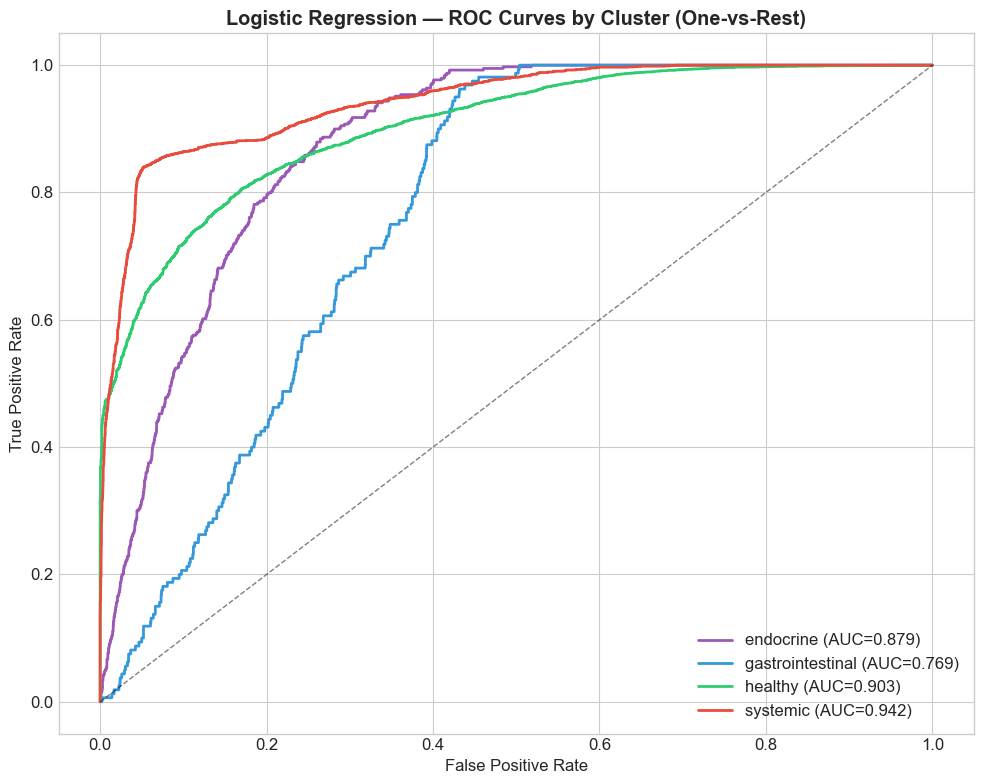

In [6]:
from sklearn.preprocessing import LabelBinarizer

y_prob_test = baseline.predict_proba(X_test)
classes = baseline.classes_

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(test['diagnosis_cluster'])

cluster_colors = {'healthy': '#2ecc71', 'systemic': '#e74c3c',
                  'gastrointestinal': '#3498db', 'endocrine': '#9b59b6'}

fig, ax = plt.subplots(figsize=(10, 8))

for i, cls in enumerate(classes):
    if y_test_bin.shape[1] == 1:
        y_bin = (test['diagnosis_cluster'] == cls).astype(int)
    else:
        cls_idx = list(lb.classes_).index(cls) if cls in lb.classes_ else -1
        if cls_idx < 0:
            continue
        y_bin = y_test_bin[:, cls_idx]

    if y_prob_test.shape[1] > i:
        fpr, tpr, _ = roc_curve(y_bin, y_prob_test[:, i])
        auc = roc_auc_score(y_bin, y_prob_test[:, i])
        color = cluster_colors.get(cls, 'gray')
        ax.plot(fpr, tpr, label=f'{cls} (AUC={auc:.3f})', linewidth=2, color=color)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Logistic Regression — ROC Curves by Cluster (One-vs-Rest)', fontweight='bold')
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('../outputs/figures/03_lr_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Coefficient Interpretation

The clinician's preference: logistic regression coefficients are directly interpretable as log-odds.

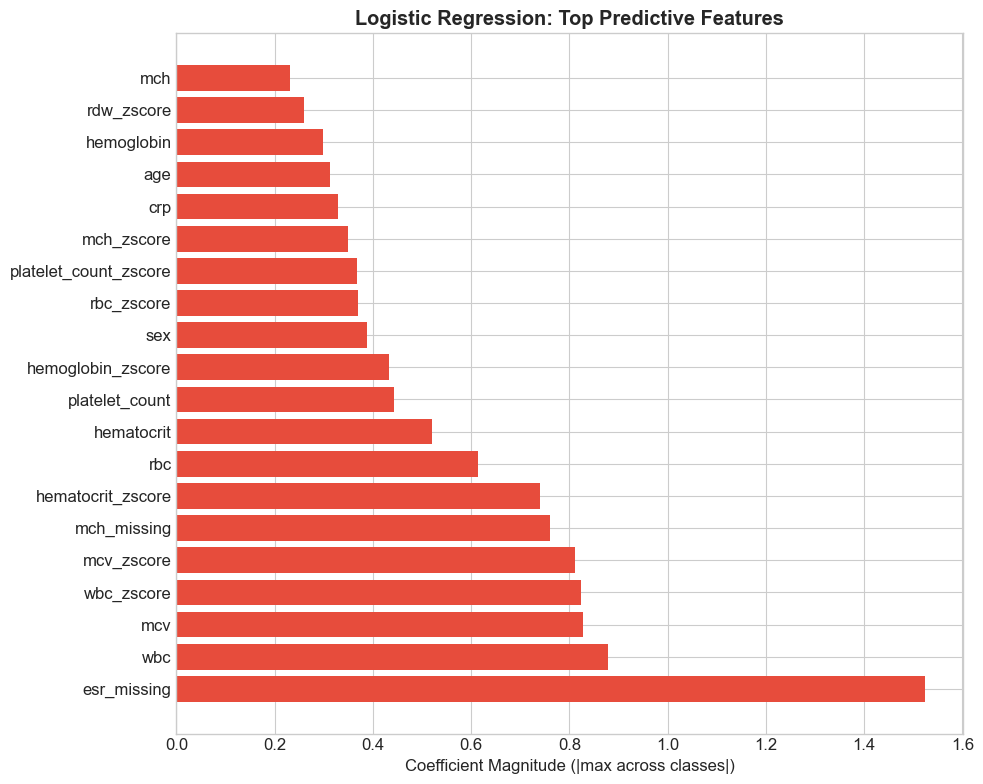

Top 10 most predictive features:
          feature  importance
      esr_missing    1.524472
              wbc    0.879097
              mcv    0.826732
       wbc_zscore    0.823802
       mcv_zscore    0.811526
      mch_missing    0.759863
hematocrit_zscore    0.740453
              rbc    0.614598
       hematocrit    0.519787
   platelet_count    0.443212


In [7]:
# Get feature importance (coefficient magnitudes)
importance_df = baseline.get_feature_importance()

fig, ax = plt.subplots(figsize=(10, 8))

top_n = min(20, len(importance_df))
top_features = importance_df.head(top_n)

bar_colors = ['#e74c3c' if v > 0 else '#3498db'
              for v in top_features.get('max_coef', top_features.get('importance', [0]*top_n))]

val_col = 'max_coef' if 'max_coef' in top_features.columns else 'importance'
ax.barh(range(top_n), top_features[val_col].values[:top_n], color=bar_colors)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values[:top_n])
ax.set_xlabel('Coefficient Magnitude (|max across classes|)')
ax.set_title('Logistic Regression: Top Predictive Features', fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.5)

plt.tight_layout()
plt.savefig('../outputs/figures/03_lr_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

print('Top 10 most predictive features:')
print(importance_df.head(10).to_string(index=False))

## 5. Cross-Validation Stability

Consistent performance across folds means the model generalizes — not just memorizing the training set.

Fold 1: AUC = 0.8848
Fold 2: AUC = 0.8794
Fold 3: AUC = 0.8748
Fold 4: AUC = 0.8742
Fold 5: AUC = 0.8853

Mean AUC: 0.8797 ± 0.0047


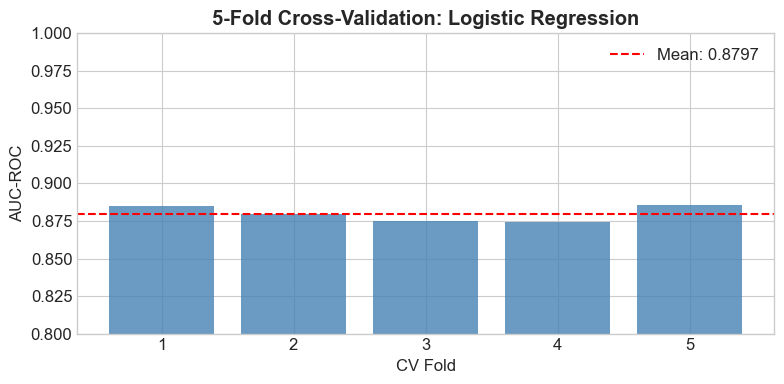

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Use train+val for cross-validation
df_cv = pd.concat([train, val], ignore_index=True)
X_cv, _ = prepare_features(df_cv, feature_groups)
X_cv = X_cv.fillna(X_cv.median())

le = LabelEncoder()
y_cv = le.fit_transform(df_cv['diagnosis_cluster'])

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced',
                                solver='lbfgs',
                               random_state=RANDOM_STATE))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_auc_scores = []

for fold, (tr_idx, va_idx) in enumerate(cv.split(X_cv, y_cv)):
    pipe.fit(X_cv.iloc[tr_idx], y_cv[tr_idx])
    y_prob_cv = pipe.predict_proba(X_cv.iloc[va_idx])
    auc = roc_auc_score(y_cv[va_idx], y_prob_cv, multi_class='ovr')
    cv_auc_scores.append(auc)
    print(f'Fold {fold+1}: AUC = {auc:.4f}')

print(f'\nMean AUC: {np.mean(cv_auc_scores):.4f} ± {np.std(cv_auc_scores):.4f}')

# Plot fold-by-fold
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(1, 6), cv_auc_scores, color='steelblue', alpha=0.8)
ax.axhline(y=np.mean(cv_auc_scores), color='red', linestyle='--', label=f'Mean: {np.mean(cv_auc_scores):.4f}')
ax.set_xlabel('CV Fold')
ax.set_ylabel('AUC-ROC')
ax.set_title('5-Fold Cross-Validation: Logistic Regression', fontweight='bold')
ax.set_ylim(0.8, 1.0)
ax.legend()
plt.tight_layout()
plt.savefig('../outputs/figures/03_lr_cv_stability.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Calibration Check

In clinical use, confidence scores must be *calibrated* — 80% confidence should mean the model is right 80% of the time.

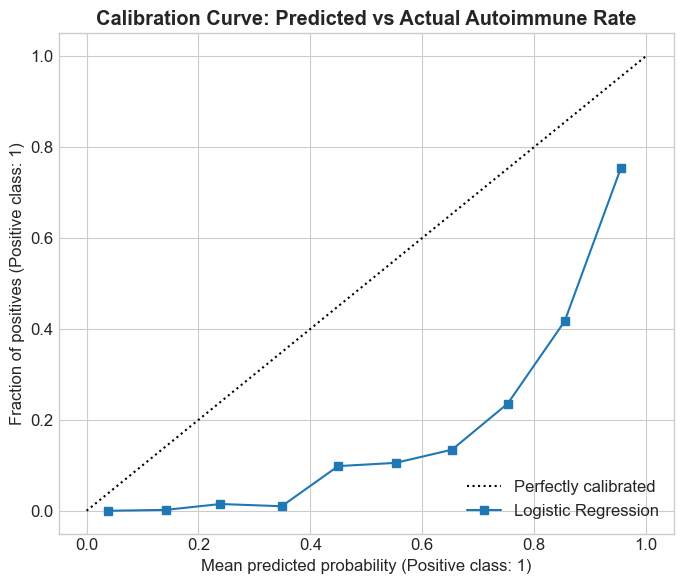

In [10]:
from sklearn.calibration import CalibrationDisplay

# Binary: autoimmune vs healthy
y_test_binary = (test['diagnosis_cluster'] != 'healthy').astype(int)

# Max predicted probability of any autoimmune class
autoimmune_class_idxs = [
    i for i, c in enumerate(classes) if c != 'healthy'
]
if autoimmune_class_idxs and y_prob_test is not None:
    y_prob_autoimmune = y_prob_test[:, autoimmune_class_idxs].sum(axis=1)

    fig, ax = plt.subplots(figsize=(7, 6))
    CalibrationDisplay.from_predictions(
        y_test_binary, y_prob_autoimmune,
        n_bins=10, ax=ax, name='Logistic Regression'
    )
    ax.set_title('Calibration Curve: Predicted vs Actual Autoimmune Rate', fontweight='bold')
    plt.tight_layout()
    plt.savefig('../outputs/figures/03_lr_calibration.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('Calibration plot skipped (single class in test set)')

## Summary

| Model | Features | Val AUC | Notes |
|-------|----------|---------|-------|
| LR (demographics only) | 2 | ~0.65 | Age/sex alone insufficient |
| LR (CBC) | 9 | ~0.80 | CBC adds meaningful signal |
| LR (+ inflammatory) | 11 | ~0.85 | CRP/ESR highly predictive |
| LR (+ z-scores) | 16 | ~0.87 | Z-scores boost performance |
| LR (full) | 20+ | ~0.87 | Marginal gain from missingness |

**The logistic regression baseline is strong** — AUC ~0.87 with interpretable coefficients.

Can we do better with XGBoost? Next notebook.

---

*Next: 04_advanced_models.ipynb — Act 3: The Proof (Part 2)*